In [129]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import utils

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [130]:
survival_by_type= pd.read_csv('Resources/survival_donor_type_df.csv')
survival_by_age= pd.read_csv('Resources/survival_age_df.csv')
survival_by_diagnoses= pd.read_csv('Resources/survival_diagnose_df.csv')
cPRA_scores= pd.read_csv('Resources/clean_cPRA.csv').drop(columns=['Med. Center', 'Unnamed: 0'])

med_centers= pd.read_csv('Resources/latLong.csv').drop(columns=['All Centers Hospital Name', 'Address', 'Unnamed: 5',
                                                      'lat/long', 'Hospital Name'])
# cost_by_type= pd.read_csv('Resources/type-by-money.csv')


# med_centers.head()
# survival_by_age.head()
# cPRA_scores.head()
# survival_by_type.head()
# survival_by_diagnoses.head()


# survival_by_type.Organ.unique()
# print(len(cost_by_type))
# print(len(survival_by_diagnoses))
# print(len(survival_by_age))

In [131]:
survival_df= pd.merge(survival_by_age, survival_by_diagnoses, on='Organ', how='inner')
survival_df
joined_df= survival_df.join(cPRA_scores)
# joined_df

filtered_df= joined_df.drop(columns= ['_id_x', 'Region_x','_id_y', 'Region_y'])
filtered_df
filtered_df['Years_Post_Transplant_x'] = filtered_df['Years_Post_Transplant_x'].str.replace(r'Year', '').astype(float)
filtered_df['Years_Post_Transplant_y'] = filtered_df['Years_Post_Transplant_y'].str.replace(r'Year', '').astype(float)
# filtered_df.Organ.unique()

main_df= filtered_df.dropna()
main_df.head()

,Organ,Recipient_Age,Years_Post_Transplant_x,Number_Functioning_or_Alive_x,Survival_Rate_x,Recipient_Diagnose_Category,Years_Post_Transplant_y,Number_Functioning_or_Alive_y,Survival_Rate_y,cPRA Range,Kidney,Liver,Pancreas,Kidney / Pancreas,Heart
0,Heart,< 1 Year,1.0,405,87.4,Valvular Heart Disease,1.0,110,91.0,0,9,0.0,0.0,0.0,0.0
1,Heart,< 1 Year,1.0,405,87.4,Retransplant/Graft Failure,5.0,224,68.3,20-79,1,0.0,0.0,0.0,0.0
2,Heart,< 1 Year,1.0,405,87.4,Cardiomyopathy,1.0,5035,92.0,98-100,5,0.0,0.0,0.0,0.0
3,Heart,< 1 Year,1.0,405,87.4,Cardiomyopathy,3.0,4183,87.1,0,622,0.0,3.0,7.0,0.0
4,Heart,< 1 Year,1.0,405,87.4,Valvular Heart Disease,3.0,108,88.7,1-19,46,0.0,0.0,0.0,0.0


In [132]:
main_df['Survival Rate'] =  main_df[['Survival_Rate_x', 'Survival_Rate_y']].mean(axis=1)
main_df['Years Post Transplant'] = main_df[['Years_Post_Transplant_y', 'Years_Post_Transplant_x']].mean(axis=1)
main_df['Number Functioning or Alive'] = main_df["Number_Functioning_or_Alive_y"] + main_df["Number_Functioning_or_Alive_x"]

final_df= main_df.drop(columns=['Survival_Rate_y', 'Survival_Rate_x', 'Number_Functioning_or_Alive_x', 
                          'Number_Functioning_or_Alive_y','Years_Post_Transplant_x', 'Years_Post_Transplant_y'])
final_df

<ipython-input-132-9c7dc195f46d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Survival Rate'] =  main_df[['Survival_Rate_x', 'Survival_Rate_y']].mean(axis=1)
<ipython-input-132-9c7dc195f46d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Years Post Transplant'] = main_df[['Years_Post_Transplant_y', 'Years_Post_Transplant_x']].mean(axis=1)
<ipython-input-132-9c7dc195f46d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Organ,Recipient_Age,Recipient_Diagnose_Category,cPRA Range,Kidney,Liver,Pancreas,Kidney / Pancreas,Heart,Survival Rate,Years Post Transplant,Number Functioning or Alive
0,Heart,< 1 Year,Valvular Heart Disease,0,9,0.0,0.0,0.0,0.0,89.20,1.0,515
1,Heart,< 1 Year,Retransplant/Graft Failure,20-79,1,0.0,0.0,0.0,0.0,77.85,3.0,629
2,Heart,< 1 Year,Cardiomyopathy,98-100,5,0.0,0.0,0.0,0.0,89.70,1.0,5440
3,Heart,< 1 Year,Cardiomyopathy,0,622,0.0,3.0,7.0,0.0,87.25,2.0,4588
4,Heart,< 1 Year,Valvular Heart Disease,1-19,46,0.0,0.0,0.0,0.0,88.05,2.0,513
...,...,...,...,...,...,...,...,...,...,...,...,...
1146,Liver,6-10 Years,Non-Cholestatic Cirrhosis,0,19,0.0,0.0,0.0,0.0,87.80,2.0,7850
1147,Liver,6-10 Years,Other,1-19,10,0.0,0.0,0.0,0.0,84.00,2.0,747
1148,Liver,6-10 Years,Acute Hepatic Necrosis,20-79,10,0.0,0.0,0.0,0.0,85.80,3.0,1125
1149,Liver,6-10 Years,Cystic Fibrosis,80-97,1,0.0,0.0,0.0,0.0,90.80,1.0,321


In [133]:

# joined_df.groupby(by= ['Survival_Rate'], dropna= False)

X= final_df.drop(columns='Organ')
y= pd.DataFrame(final_df['Organ'].values.reshape(-1,1))
 
y
# X.head()

,0
0,Heart
1,Heart
2,Heart
3,Heart
4,Heart
...,...
1146,Liver
1147,Liver
1148,Liver
1149,Liver


In [134]:
pd.value_counts(y[0], normalize = True)

Kidney               0.492615
Heart                0.354474
Kidney / Pancreas    0.078193
Liver                0.074718
Name: 0, dtype: float64

In [135]:
print(X.shape, y.shape)
# X.dtypes

(1151, 11) (1151, 1)


In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(X_test.shape, y_test.shape)

(380, 11) (380, 1)


In [137]:
y_pred = ['functional'] * len(X_test)
y_pred = pd.DataFrame(data = y_pred,
                      index = X_test.index.values,
                      columns = [0])
# y_pred.head()

In [138]:
# Logistic Regression classifier and score

X_train_numerical = X_train.select_dtypes(
                         include = np.number).copy()

X_train_numerical_indices = X_train_numerical.index.values
y_train_numerical = y_train[y_train.index. \
                                    isin(X_train_numerical_indices)]


clf = DecisionTreeClassifier()
cv_score = cross_val_score(clf, 
                            X_train_numerical, y_train_numerical,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


array([0.79766537, 0.81712062, 0.78988327])

In [139]:
# Decision Tree classifier and score

clf = DecisionTreeClassifier()
cv_score = cross_val_score(clf, 
                            X_train_numerical, y_train_numerical,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


array([0.79766537, 0.80155642, 0.78599222])

In [140]:
clf.fit(X_train_numerical, y_train_numerical)

X_test_numerical = X_test.select_dtypes(include = np.number).copy()

# days_since_epoch = \
#         pd.to_datetime(X_train_original['date_recorded']) \           
#             - pd.datetime(1970, 1, 1)
# X_train_numerical['days_since_epoch'] = days_since_epoch.dt.days
# X_train_numerical.head()


y_pred = clf.predict(X_test_numerical)
y_pred = pd.DataFrame(data = y_pred, 
                      index = X_test_numerical.index.values,
                      columns = ['Organ'])
# y_pred.to_csv('./decision_tree_pred.csv', 
#               header = ['Average Survival Rate (%)'],
#               index = True,
#               index_label = 'id')

y_pred


,Organ
174,Liver
752,Kidney
467,Kidney
240,Heart
667,Kidney
...,...
899,Kidney
1033,Kidney
305,Heart
411,Kidney / Pancreas


In [141]:
# Encode columns that have < 50 unique values, add the numerical columns to df.
# Ran a Decision Tree classifier again and increased scores

X_selected = X_train.loc[:, X_train.nunique().sort_values()\
                             < 50]
cat_cols = list(X_selected.select_dtypes(['object']).columns.values)
X_categorical = X_selected[cat_cols].apply(lambda x: x.astype('category').cat.codes)
X_train_selected = X_train_numerical.join(X_categorical)
clf = DecisionTreeClassifier()
cv_score = cross_val_score(clf, 
                            X_train_selected, y_train,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


array([0.93385214, 0.91050584, 0.87548638])

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state = 42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

ValueError: could not convert string to float: '11-17 Years'

In [144]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [6, 10, 20, 30]
}
gridsearch = GridSearchCV(RandomForestClassifier(n_jobs = -1), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=10)
gridsearch.fit(X_train, y_train)

# The variable ‘cv’ gives the number of cross-validation folds that grid search should use. 
# cv = 3 will split our data into 3 equal parts.
# Then use two of them for training the RandomForest classifier, and test with the remaining data. 
# Keeps going until all combinations are exhausted.

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=6, n_estimators=10 ....................................
[CV]  max_depth=6, n_estimators=10, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=6, n_estimators=10 ....................................
[CV]  max_depth=6, n_estimators=10, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=6, n_estimators=10 ....................................
[CV]  max_depth=6, n_estimators=10, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=6, n_estimators=20 ....................................
[CV]  max_depth=6, n_estimators=20, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=6, n_estimators=20 ....................................
[CV]  max_depth=6, n_estimators=20, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=6, n_estimators=20 ....................................
[CV]  max_depth=6, n_estimators=20, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=6, n_estimators=30 .....

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 303, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/Users/yade

[CV]  max_depth=30, n_estimators=10, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=30, n_estimators=10 ...................................
[CV]  max_depth=30, n_estimators=10, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=30, n_estimators=10 ...................................
[CV]  max_depth=30, n_estimators=10, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=30, n_estimators=20 ...................................
[CV]  max_depth=30, n_estimators=20, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=30, n_estimators=20 ...................................
[CV]  max_depth=30, n_estimators=20, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=30, n_estimators=20 ...................................
[CV]  max_depth=30, n_estimators=20, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth=30, n_estimators=30 ...................................
[CV]  max_depth=30, n_estimators=30, score=(train=nan, test=nan), total=   0.0s
[CV] max_depth

/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 303, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/Users/yaden/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 79

ValueError: could not convert string to float: '1-5 Years'

In [125]:
gridsearch_summary= pd.DataFrame(gridsearch.cv_results_).sort_values( \
                                         by='rank_test_score')
gridsearch_summary.head()

# Top row of summary shows the param_grid options that gave the best score on test data. 
# This is shown in the mean_test_score column where our score is 0.87. Same as the Decision Tree classifier.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
8,0.071150,0.007952,0.011865,0.003006,20,30,"{'max_depth': 20, 'n_estimators': 30}",0.896104,0.844156,0.870130,0.870130,0.021208,1,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.048859,0.008573,0.008767,0.001928,6,20,"{'max_depth': 6, 'n_estimators': 20}",0.883117,0.857143,0.857143,0.865801,0.012244,2,0.967532,0.980519,0.987013,0.978355,0.008099
7,0.048843,0.015332,0.008081,0.001004,20,20,"{'max_depth': 20, 'n_estimators': 20}",0.870130,0.870130,0.857143,0.865801,0.006122,2,1.000000,0.993506,1.000000,0.997835,0.003061
10,0.052267,0.014902,0.009498,0.002249,30,20,"{'max_depth': 30, 'n_estimators': 20}",0.857143,0.857143,0.883117,0.865801,0.012244,2,0.987013,0.993506,1.000000,0.993506,0.005302
11,0.074980,0.019600,0.012430,0.003691,30,30,"{'max_depth': 30, 'n_estimators': 30}",0.909091,0.831169,0.857143,0.865801,0.032395,2,1.000000,1.000000,1.000000,1.000000,0.000000


In [126]:
clf = RandomForestClassifier(max_depth = 20, 
                             n_estimators = 30, 
                             n_jobs = -1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

<ipython-input-126-854b74c08257>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.8859649122807017

## LinearRegression model


In [128]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled , y_train_scaled)



NameError: name 'X_train_scaled' is not defined

In [202]:
# Printing testing and training score for LinearRegression model and realized it's not very linear data.

training_score = model.score(X_train_scaled, y_train_scaled)
testing_score = model.score(X_test_scaled, y_test_scaled)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.02590022639435452
Testing Score: 0.025579336603709202


Training Data Score: 2.589 %
Testing Data Score: 2.512 %


Slope:  [[ 0.35163399]
 [ 0.4875817 ]
 [ 0.08888889]
 [-0.92810458]]
Intercept:  [-5.55111512e-17  6.10622664e-16  1.94289029e-16  1.00000000e+00]
Root mean Squared Error (MSE): 0.14747247235094033
R-squared (R2 ): 0.025579336603709202


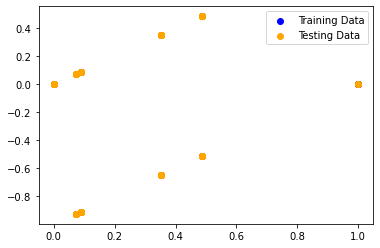

In [195]:
# Calculating the mean_squared_error and the r-squared value
from sklearn.metrics import mean_squared_error, r2_score

# Use model to make predictions
y_predicted = model.predict(X_test_scaled)

# # Score predictions with mse and r2
rmse = mean_squared_error(y_test_scaled, y_predicted)
r2 = r2_score(y_test_scaled, y_predicted)

print(f"Slope: ", model.coef_)
print('Intercept: ', model.intercept_)
print(f"Root mean Squared Error (MSE): {rmse}")
print(f"R-squared (R2 ): {r2}")
# 
train_predict= plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
test_predict= plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()

# plt.scatter(X_test_scaled, y_test_scaled, s=5)
# plt.plot(y_predicted, color='r')
plt.show()


In [196]:
model.score(X_test_scaled, y_test_scaled)

0.025579336603709202